# Power-pairing vs random pairing

_Chuan-Zheng Lee <czlee@stanford.edu>_

This notebook shows a very basic simulation of debate tournaments using power-pairing and random pairing, comparing the variance in actual rank caused by randomness in the draw in both systems.

The functions below are run by the plotting code to simulate tournaments. Scroll down to see the plots.

In [1]:
using PyPlot

In [2]:
function runpairings!(points, pairings, strengths)
    for (t1, t2) in pairings
        if strengths[t2] > strengths[t1]
            points[t2] += 1
        else
            points[t1] += 1
        end
    end
end

function groupbrackets(points)
    maxpoints = maximum(points)
    brackets = [[] for p in 0:maxpoints]
    for (t, p) in enumerate(points)
        push!(brackets[p+1], t)
    end
    return brackets
end

function pairrandom(brackets)
    teams = vcat(brackets...)
    shuffled = shuffle(teams)
    return collect(zip(shuffled[1:end÷2], shuffled[end÷2+1:end]))
end

function pairpower(brackets)
    pairings = []
    odd = -1
    for teams in brackets
        if odd != -1 # pull-up team
            push!(teams, odd)
            odd = -1
        end
        shuffled = shuffle(teams)
        if length(teams) % 2 == 1
            odd = pop!(teams)
        end
        pairs = collect(zip(shuffled[1:end÷2], shuffled[end÷2+1:end]))
        append!(pairings, pairs)
    end
    @assert odd == -1 # there should not be a pull-up left over at the end
    return pairings
end

function getrankedteams(brackets)
    teams = vcat([sort(bracket) for bracket in reverse(brackets)]...)
end

function simulatetournament(pairingfunction::Function, strengths, nrounds)
    points = zeros(Int, length(strengths))
    brackets = Vector{Vector{Int64}}(1)
    brackets[1] = collect(1:length(strengths))
    for i in 1:nrounds
        pairings = pairingfunction(brackets)
        runpairings!(points, pairings, strengths)
        brackets = groupbrackets(points)
    end
    return brackets
end

function simulatemanytournaments(pairingfunction::Function, ntournaments::Int, nteams::Int, nrounds::Int)
    strengths = collect(nteams:-1:1)
    positions = [[] for t in strengths]
    for i in 1:ntournaments
        brackets = simulatetournament(pairingfunction, strengths, nrounds)
        rankedteams = getrankedteams(brackets)
        for (pos, team) in enumerate(rankedteams)
            push!(positions[team], pos)
        end
    end
    return positions
end;

# Simulation parameters

If you're running this in Jupyter Notebook, you can change the parameters of the simulations below. It will run `ntournaments` tournaments with `nrounds` rounds in each tournament, each tournament having `nteams` teams.

I haven't tried it myself, but I suspect the behavior of each system depends quite a bit on these parameters. The arguments we make are for typical debate tournaments, in which there are far fewer rounds than there are teams (thus preventing us from just running a round robin).

In [3]:
ntournaments = 100
nteams = 50
nrounds = 5;

# Plots 

In the box-and-whisker plots below, each box (column) is a team, best team on the left, worst team on the right. The box shows the distribution of _actual_ ranks from each of the simulated tournaments. Some important assumptions and notes:

* We model teams' "true" abilities as being ranked from first to last, and a "better" team _always_ beats a "worse" team (not just most of the time).
* For power-pairing, teams are randomly paired within brackets.
* When generating the final _actual_ rank from a tournament, however, teams are assumed to ranked "correctly" within brackets. So teams are ranked first by bracket, then by "true ability". This is advantageous to both systems, of course; you can think of it as modelling an assumption that within brackets, speaker scores will be a proxy for "true ability". (This doesn't work so well for draw strength/opp wins.)
* Other than that, there's no concept of speaker scores in the model. Perhaps it might be an interesting exercise to model this, but that would also reduce the ability of this simulation to capture the essence of the question at hand.
* This model uses two-team formats (like most North American, Oceanian and Asian styles), not British Parliamentary.

The ideal would be a series of zero-height boxes (which would just look like red dashes) along the $y=x$ line, _i.e._ the team with true rank $x$ should always have actual rank $x$ (with no variance). Note that the first and last teams will always come first and last with both tournament structures, because they will win and lose respectively all their debates. It's the teams in the middle where variance comes into play.

**Power-pairing** results in some variance. There's an interesting, but unsurprising, effect with outliers at the bracket boundaries. If a team draws a lucky or unlucky opponent within their bracket, they might end up in the "wrong bracket" at the end, which catapults them up or down the tab. This can happen, but not too often. In most cases, going into a lower bracket the next round "saves" an unlucky team. By and large, the variance isn't totally unbearable.

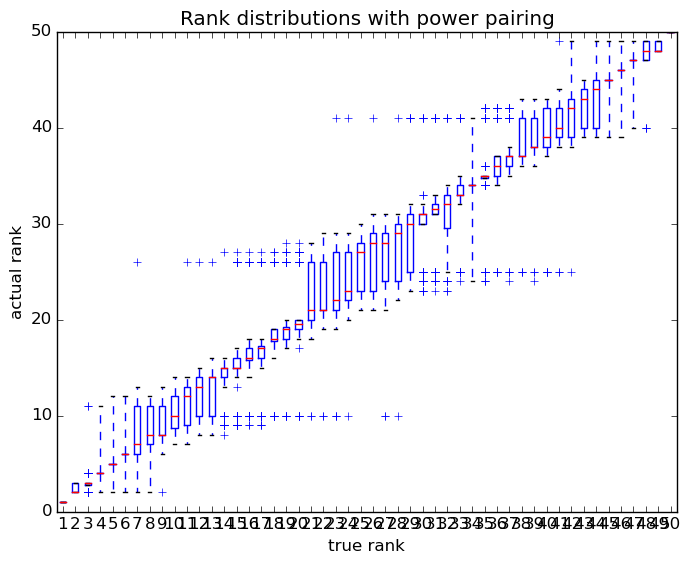

In [4]:
powerpositions = simulatemanytournaments(pairpower, ntournaments, nteams, nrounds)
powerplot = boxplot(powerpositions)
xlabel("true rank")
ylabel("actual rank")
title("Rank distributions with power pairing");

**Random pairing**, on the other hand, is all over the place. Again, the first and last teams come first and last. But teams in the middle have both bigger quartile spreads and bigger whisker ranges (excluding outliers). This means there's a much weaker relationship between one's actual rank in any one given tournament and their true rank (and the sole other variable in this model is randomness in the draw).

This, again, isn't surprising. There's a lot more randomness in the system now, so luck of the draw factors in every round. If you have very many rounds—as many as there are teams—each team will converge individually to their true rank. But because there are so few rounds, drawing multiple weak or strong opponents doesn't take that much luck.

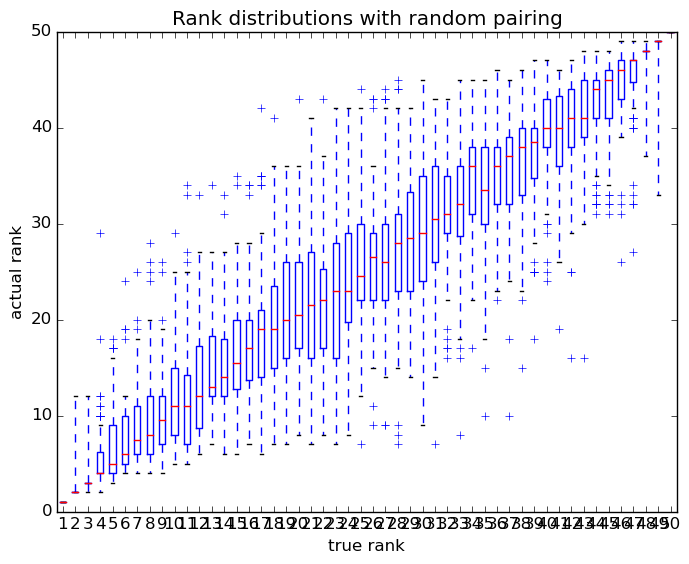

In [5]:
randompositions = simulatemanytournaments(pairrandom, ntournaments, nteams, nrounds)
randomplot = boxplot(randompositions)
xlabel("true rank")
ylabel("actual rank")
title("Rank distributions with random pairing");

How unlucky do you have to be to draw, say, three strong opponents in an eight-round tournament? Contrary to what you might think, it's not a rare scenario. We can compute the probability of any _given_ team at some percentile rank drawing such opponents using the binomial distribution. Because it's hard to pick a team that should be our "example" rank, we just plot every team's probability of not breaking as a function of their percentile rank. The below plot only plots within the range of the expected break cut-off.

Now, teams close to the break cut-off wouldn't have much cause to complain. In any system, you'd always expect the borderline team to have a half-chance of breaking. The salient group is that in the middle two quartiles of the break: not safe, but also not borderline.

But also, remember this is the probability for any _one_ team of some percentile rank. The probability that any _one_ (or say, three, because one upset doesn't really break a tournament) team in the "true break" being affected would be much higher.

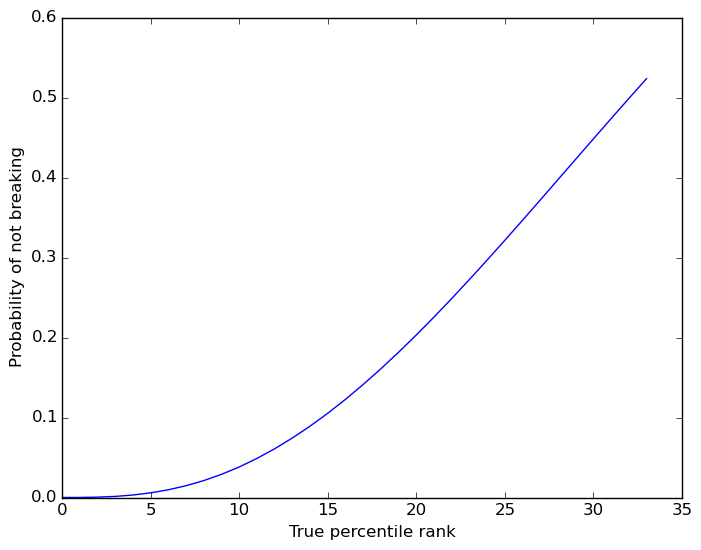

In [6]:
rounds = 8
wins_to_break = 6

ranks = 0:0.01:(rounds+1-wins_to_break)/(rounds+1) # plot up to the expected break cut-off
probnotbreak(rank) = sum([(1-rank)^i*rank^(rounds-i)*binomial(rounds,i) for i in 0:wins_to_break-1])
probs = map(probnotbreak, ranks)
plot(ranks*100, probs)
xlabel("True percentile rank")
ylabel("Probability of not breaking");